# **Urdu Sentiment Classification**

## **Assignment 3** 
- **Ahmed Abdullah 22L-7503**
- **Ibrahim Zia 22L-7516**

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import AutoModel, AutoTokenizer
from typing import FrozenSet
from wordcloud import WordCloud
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import RobertaTokenizer, RobertaModel
from tqdm import tqdm
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from transformers import TFBertModel, BertTokenizer
import tensorflow as tf
import warnings
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN,Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, GRU
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score,confusion_matrix,classification_report

warnings.filterwarnings("ignore")

### **Loading Dataset** 

In [41]:
df = pd.read_csv('../input/urdu-sentiment-corpus-v1/urdu-sentiment-corpus-v1.tsv', sep='\t')
df.head()

Tweet Class
0  ŸÖ€å⁄∫ ŸÜ€í ÿß€åŸπŸÖ ÿ®ŸÖ ÿ®ŸÜÿß€åÿß ⁄æ€í €î€î€î€îÿßŸà ÿ®⁄æÿßÿ¶€å ÿß€åŸπŸÖ ÿ®ŸÖÿ® ...     P
1  ⁄ÜŸÜÿØ€í ÿ≥€í ÿßŸÜŸÇŸÑÿßÿ® ÿßŸàÿ± ÿπŸÖÿ±ÿßŸÜ ÿÆÿßŸÜ Ÿàÿ≤€åÿ± ÿßÿπÿ∏ŸÖ ŸÜ€Å€å⁄∫ ÿ®ŸÜ...     N
2                           ŸπŸà€åŸπÿ± ⁄©ÿß ÿÆ€åÿßŸÑ ⁄©€åÿ≥€í ÿ¢€åÿß ÿü     O
3  ÿ≥ÿ±⁄Ü ÿßŸÜÿ¨ŸÜ ⁄ØŸà⁄ØŸÑ ⁄©€í ŸÜÿßÿ¶ÿ® ÿµÿØÿ± ŸÜ€í ŸÅÿ∂ÿß ŸÖ€å⁄∫ ÿå 130,000...     P
4    ÿßÿ®⁄æ€å ÿ™⁄© ÿßÿ≥⁄©€å ŸÑ€Åÿ±€å⁄∫ ⁄©ÿ®⁄æ€å ⁄©ÿ®⁄æ€å ÿ¢ ÿ¨ÿßÿ™€å €Å€å⁄∫ €åÿßÿ± :ÿ£Ÿí     P

### **Exploring Data**

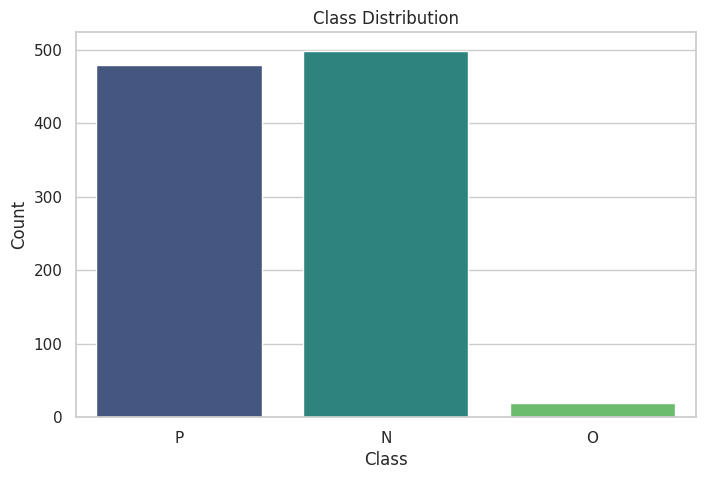

In [42]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 5))
sns.countplot(x="Class", data=df, palette="viridis")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

## **Text Preprocessing**
### **Basic Functions**

In [43]:
STOP_WORDS: FrozenSet[str] = frozenset("""

 ÿ¢ ÿ¢ÿ¶€å ÿ¢ÿ¶€å⁄∫ ÿ¢ÿ¶€í ÿ¢ÿ™ÿß ÿ¢ÿ™€å ÿ¢ÿ™€í ÿ¢ÿ≥ ÿ¢ŸÖÿØ€åÿØ ÿ¢ŸÜÿß ÿ¢ŸÜÿ≥€Å ÿ¢ŸÜ€å ÿ¢ŸÜ€í ÿ¢Ÿæ ÿ¢⁄Ø€í ÿ¢€Å ÿ¢€Åÿß ÿ¢€åÿß ÿßÿ® ÿßÿ®⁄æ€å ÿßÿ®€í
 ÿßÿ±€í ÿßÿ≥ ÿßÿ≥⁄©ÿß ÿßÿ≥⁄©€å ÿßÿ≥⁄©€í ÿßÿ≥€å ÿßÿ≥€í ÿßŸÅ ÿßŸÅŸà€Å ÿßŸÑÿ®ÿ™€Å ÿßŸÑŸÅ ÿßŸÜ ÿßŸÜÿØÿ± ÿßŸÜ⁄©ÿß ÿßŸÜ⁄©€å ÿßŸÜ⁄©€í ÿßŸÜ€ÅŸà⁄∫ ÿßŸÜ€Å€å ÿßŸÜ€Å€å⁄∫ ÿßŸàÿ¶€í ÿßŸàÿ± ÿßŸàŸæÿ±
 ÿßŸà€ÅŸà ÿßŸæ ÿßŸæŸÜÿß ÿßŸæŸÜŸà⁄∫ ÿßŸæŸÜ€å ÿßŸæŸÜ€í ÿßŸæŸÜ€íÿ¢Ÿæ ÿß⁄©ÿ´ÿ± ÿß⁄Øÿ± ÿß⁄Øÿ±⁄Ü€Å ÿß€Åÿß€Åÿß ÿß€åÿ≥ÿß ÿß€åÿ≥€å ÿß€åÿ≥€í ÿß€å⁄© ÿ®ÿßÿ¶€å⁄∫ ÿ®ÿßÿ± ÿ®ÿßÿ±€í ÿ®ÿßŸÑ⁄©ŸÑ ÿ®ÿßŸàÿ¨ŸàÿØ ÿ®ÿß€Åÿ±
 ÿ®ÿ¨ ÿ®ÿ¨€í ÿ®ÿÆ€åÿ± ÿ®ÿ¥ÿ±ÿ∑€å⁄©€Å ÿ®ÿπÿØ ÿ®ÿπÿ∂ ÿ®ÿ∫€åÿ± ÿ®ŸÑ⁄©€Å ÿ®ŸÜ ÿ®ŸÜÿß ÿ®ŸÜÿßÿ§ ÿ®ŸÜÿØ ÿ®⁄ë€å ÿ®⁄æÿ± ÿ®⁄æÿ±€å⁄∫ ÿ®⁄æ€å ÿ®€Åÿ™ ÿ®€Åÿ™ÿ± ÿ™ÿß⁄©€Å ÿ™ÿß€ÅŸÖ ÿ™ÿ® ÿ™ÿ¨⁄æ
 ÿ™ÿ¨⁄æ€å ÿ™ÿ¨⁄æ€í ÿ™ÿ±ÿß ÿ™ÿ±€å ÿ™ŸÑ⁄© ÿ™ŸÖ ÿ™ŸÖÿßŸÖ ÿ™ŸÖ€Åÿßÿ±ÿß ÿ™ŸÖ€Åÿßÿ±Ÿà⁄∫ ÿ™ŸÖ€Åÿßÿ±€å ÿ™ŸÖ€Åÿßÿ±€í ÿ™ŸÖ€Å€å⁄∫ ÿ™Ÿà ÿ™⁄© ÿ™⁄æÿß ÿ™⁄æ€å ÿ™⁄æ€å⁄∫ ÿ™⁄æ€í ÿ™€åÿ±ÿß ÿ™€åÿ±€å ÿ™€åÿ±€í
 ÿ¨ÿß ÿ¨ÿßÿ§ ÿ¨ÿßÿ¶€å⁄∫ ÿ¨ÿßÿ¶€í ÿ¨ÿßÿ™ÿß ÿ¨ÿßÿ™€å ÿ¨ÿßÿ™€í ÿ¨ÿßŸÜ€å ÿ¨ÿßŸÜ€í ÿ¨ÿ® ÿ¨ÿ®⁄©€Å ÿ¨ÿØ⁄æÿ± ÿ¨ÿ≥ ÿ¨ÿ≥€í ÿ¨ŸÜ ÿ¨ŸÜÿßÿ® ÿ¨ŸÜ€ÅŸà⁄∫ ÿ¨ŸÜ€Å€å⁄∫ ÿ¨Ÿà ÿ¨€Åÿß⁄∫ ÿ¨€å ÿ¨€åÿ≥ÿß
 ÿ¨€åÿ≥Ÿà⁄∫ ÿ¨€åÿ≥€å ÿ¨€åÿ≥€í ÿ≠ÿßŸÑÿßŸÜ⁄©€Å ÿ≠ÿßŸÑÿß⁄∫ ÿ≠ÿµ€Å ÿ≠ÿ∂ÿ±ÿ™ ÿÆÿßÿ∑ÿ± ÿÆÿßŸÑ€å ÿÆŸàÿß€Å ÿÆŸàÿ® ÿÆŸàÿØ ÿØÿßÿ¶€å⁄∫ ÿØÿ±ŸÖ€åÿßŸÜ ÿØÿ±€å⁄∫ ÿØŸà ÿØŸàÿ±ÿßŸÜ ÿØŸàÿ≥ÿ±ÿß ÿØŸàÿ≥ÿ±Ÿà⁄∫ ÿØŸàÿ≥ÿ±€å ÿØŸà⁄∫
 ÿØ⁄©⁄æÿßÿ¶€å⁄∫ ÿØ€å ÿØ€åÿ¶€í ÿØ€åÿß ÿØ€åÿ™ÿß ÿØ€åÿ™€å ÿØ€åÿ™€í ÿØ€åÿ± ÿØ€åŸÜÿß ÿØ€åŸÜ€å ÿØ€åŸÜ€í ÿØ€å⁄©⁄æŸà ÿØ€å⁄∫ ÿØ€å€í ÿØ€í ÿ∞ÿ±€åÿπ€í ÿ±⁄©⁄æÿß ÿ±⁄©⁄æÿ™ÿß ÿ±⁄©⁄æÿ™€å ÿ±⁄©⁄æÿ™€í ÿ±⁄©⁄æŸÜÿß ÿ±⁄©⁄æŸÜ€å
 ÿ±⁄©⁄æŸÜ€í ÿ±⁄©⁄æŸà ÿ±⁄©⁄æ€å ÿ±⁄©⁄æ€í ÿ±€Å ÿ±€Åÿß ÿ±€Åÿ™ÿß ÿ±€Åÿ™€å ÿ±€Åÿ™€í ÿ±€ÅŸÜÿß ÿ±€ÅŸÜ€å ÿ±€ÅŸÜ€í ÿ±€ÅŸà ÿ±€Å€å ÿ±€Å€å⁄∫ ÿ±€Å€í ÿ≥ÿßÿ™⁄æ ÿ≥ÿßŸÖŸÜ€í ÿ≥ÿß⁄ë⁄æ€í ÿ≥ÿ® ÿ≥ÿ®⁄æ€å
 ÿ≥ÿ±ÿßÿ≥ÿ± ÿ≥ŸÖ€åÿ™ ÿ≥Ÿàÿß ÿ≥Ÿàÿßÿ¶€í ÿ≥⁄©ÿß ÿ≥⁄©ÿ™ÿß ÿ≥⁄©ÿ™€í ÿ≥€Å ÿ≥€Å€å ÿ≥€å ÿ≥€í ÿ¥ÿß€åÿØ ÿ¥⁄©ÿ±€å€Å ÿµÿßÿ≠ÿ® ÿµÿßÿ≠ÿ®€Å ÿµÿ±ŸÅ ÿ∂ÿ±Ÿàÿ± ÿ∑ÿ±ÿ≠ ÿ∑ÿ±ŸÅ ÿ∑Ÿàÿ± ÿπŸÑÿßŸà€Å ÿπ€åŸÜ
 ŸÅŸÇÿ∑ ŸÅŸÑÿß⁄∫ ŸÅ€å ŸÇÿ®ŸÑ ŸÇÿ∑ÿß ŸÑÿ¶€í ŸÑÿßÿ¶€å ŸÑÿßÿ¶€í ŸÑÿßÿ™ÿß ŸÑÿßÿ™€å ŸÑÿßÿ™€í ŸÑÿßŸÜÿß ŸÑÿßŸÜ€å ŸÑÿßŸÜ€í ŸÑÿß€åÿß ŸÑŸà ŸÑŸàÿ¨€å ŸÑŸà⁄ØŸà⁄∫ ŸÑ⁄Ø ŸÑ⁄Øÿß ŸÑ⁄Øÿ™ÿß
 ŸÑ⁄Øÿ™€å ŸÑ⁄Ø€å ŸÑ⁄Ø€å⁄∫ ŸÑ⁄Ø€í ŸÑ€Åÿ∞ÿß ŸÑ€å ŸÑ€åÿß ŸÑ€åÿ™ÿß ŸÑ€åÿ™€å ŸÑ€åÿ™€í ŸÑ€å⁄©ŸÜ ŸÑ€å⁄∫ ŸÑ€å€í ŸÑ€í ŸÖÿßÿ≥Ÿàÿß ŸÖÿ™ ŸÖÿ¨⁄æ ŸÖÿ¨⁄æ€å ŸÖÿ¨⁄æ€í ŸÖÿ≠ÿ™ÿ±ŸÖ ŸÖÿ≠ÿ™ÿ±ŸÖ€Å ŸÖÿ≠ÿ∂
 ŸÖÿ±ÿß ŸÖÿ±ÿ≠ÿ®ÿß ŸÖÿ±€å ŸÖÿ±€í ŸÖÿ≤€åÿØ ŸÖÿ≥ ŸÖÿ≥ÿ≤ ŸÖÿ≥Ÿπÿ± ŸÖÿ∑ÿßÿ®ŸÇ ŸÖŸÑ ŸÖ⁄©ÿ±ŸÖ€å ŸÖ⁄Øÿ± ŸÖ⁄Ø⁄æÿ± ŸÖ€Åÿ±ÿ®ÿßŸÜ€å ŸÖ€åÿ±ÿß ŸÖ€åÿ±Ÿà⁄∫ ŸÖ€åÿ±€å ŸÖ€åÿ±€í ŸÖ€å⁄∫ ŸÜÿß ŸÜÿ≤ÿØ€å⁄©
 ŸÜŸÖÿß ŸÜ€Å ŸÜ€Å€å⁄∫ ŸÜ€åÿ≤ ŸÜ€å⁄Ü€í ŸÜ€í Ÿà Ÿàÿßÿ± Ÿàÿßÿ≥ÿ∑€í ŸàÿßŸÇÿπ€å ŸàÿßŸÑÿß ŸàÿßŸÑŸà⁄∫ ŸàÿßŸÑ€å ŸàÿßŸÑ€í Ÿàÿß€Å Ÿàÿ¨€Å Ÿàÿ±ŸÜ€Å Ÿàÿ∫€åÿ±€Å ŸàŸÑ€í Ÿà⁄Øÿ±ŸÜ€Å Ÿà€Å Ÿà€Åÿß⁄∫
 Ÿà€Å€å Ÿà€Å€å⁄∫ Ÿà€åÿ≥ÿß Ÿà€åÿ≥€í Ÿà€å⁄∫ Ÿæÿßÿ≥ Ÿæÿß€åÿß Ÿæÿ± Ÿæÿ≥ ŸæŸÑ€åÿ≤ ŸæŸàŸÜ ŸæŸàŸÜ€å ŸæŸàŸÜ€í Ÿæ⁄æÿ± Ÿæ€Å Ÿæ€ÅŸÑÿß Ÿæ€ÅŸÑ€å Ÿæ€ÅŸÑ€í Ÿæ€åÿ± Ÿæ€å⁄Ü⁄æ€í ⁄Üÿß€Åÿ¶€í
 ⁄Üÿß€Åÿ™€í ⁄Üÿß€Å€åÿ¶€í ⁄Üÿß€Å€í ⁄ÜŸÑÿß ⁄ÜŸÑŸà ⁄ÜŸÑ€å⁄∫ ⁄ÜŸÑ€í ⁄ÜŸÜÿß⁄Ü€Å ⁄ÜŸÜÿØ ⁄ÜŸàŸÜ⁄©€Å ⁄Ü⁄©€å ⁄Ü⁄©€å⁄∫ ⁄Ü⁄©€í ⁄àÿßŸÑŸÜÿß ⁄àÿßŸÑŸÜ€å ⁄àÿßŸÑŸÜ€í ⁄àÿßŸÑ€í ⁄©ÿ¶€í ⁄©ÿß ⁄©ÿßÿ¥ ⁄©ÿ® ⁄©ÿ®⁄æ€å
 ⁄©ÿØ⁄æÿ± ⁄©ÿ± ⁄©ÿ±ÿ™ÿß ⁄©ÿ±ÿ™€å ⁄©ÿ±ÿ™€í ⁄©ÿ±ŸÖ ⁄©ÿ±ŸÜÿß ⁄©ÿ±ŸÜ€í ⁄©ÿ±Ÿà ⁄©ÿ±€å⁄∫ ⁄©ÿ±€í ⁄©ÿ≥ ⁄©ÿ≥€å ⁄©ÿ≥€í ⁄©ŸÖ ⁄©ŸÜ ⁄©ŸÜ€Å€å⁄∫ ⁄©Ÿà ⁄©Ÿàÿ¶€å ⁄©ŸàŸÜ ⁄©ŸàŸÜÿ≥ÿß
 ⁄©ŸàŸÜÿ≥€í ⁄©⁄Ü⁄æ ⁄©€Å ⁄©€Åÿß ⁄©€Åÿß⁄∫ ⁄©€Å€Å ⁄©€Å€å ⁄©€Å€å⁄∫ ⁄©€Å€í ⁄©€å ⁄©€åÿß ⁄©€åÿ≥ÿß ⁄©€åÿ≥€í ⁄©€åŸàŸÜ⁄©ÿ± ⁄©€åŸàŸÜ⁄©€Å ⁄©€åŸà⁄∫ ⁄©€å€í ⁄©€í ⁄Øÿ¶€å ⁄Øÿ¶€í ⁄Øÿß ⁄ØŸÜÿß
 ⁄ØŸà ⁄ØŸà€åÿß ⁄Ø€å ⁄Ø€åÿß €Åÿßÿ¶€å⁄∫ €Åÿßÿ¶€í €Åÿß⁄∫ €Åÿ± €Åÿ±⁄ÜŸÜÿØ €Åÿ±⁄Øÿ≤ €ÅŸÖ €ÅŸÖÿßÿ±ÿß €ÅŸÖÿßÿ±€å €ÅŸÖÿßÿ±€í €ÅŸÖ€å €ÅŸÖ€å⁄∫ €ÅŸà €ÅŸàÿ¶€å €ÅŸàÿ¶€å⁄∫ €ÅŸàÿ¶€í €ÅŸàÿß
 €ÅŸàÿ®€ÅŸà €ÅŸàÿ™ÿß €ÅŸàÿ™€å €ÅŸàÿ™€å⁄∫ €ÅŸàÿ™€í €ÅŸàŸÜÿß €ÅŸàŸÜ⁄Ø€í €ÅŸàŸÜ€å €ÅŸàŸÜ€í €ÅŸà⁄∫ €Å€å €Å€åŸÑŸà €Å€å⁄∫ €Å€í €åÿß €åÿßÿ™ €åÿπŸÜ€å €å⁄© €å€Å €å€Åÿß⁄∫ €å€Å€å €å€Å€å⁄∫
""".split())

def remove_stopwords(text: str) -> str:
    return " ".join(word for word in text.split() if word not in STOP_WORDS)


def clean_text(text):
    text = text.lower()
    text = re.sub(r"[ŸéŸãŸèŸåŸêŸçŸíŸë]", "", text)
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\s+", " ", text).strip()
    text = remove_stopwords(text)
    
    return text

### **Testing functions**

In [44]:
text = "???€å€Å ÿß€å⁄© ŸÖÿ´ÿßŸÑ €Å€í"
print(clean_text(text))

ŸÖÿ´ÿßŸÑ


## **Application of preprocessing** 

In [45]:
df.dropna(inplace=True)
print("NULL COUNTS")
print(df.isnull().sum())
df['CleanTweet'] = df['Tweet'].apply(clean_text)
df['CleanTweet'].head()
df = df[df["Class"] != "O"]
label_encoder = LabelEncoder()
df["Class"] = label_encoder.fit_transform(df["Class"])

NULL COUNTS
Tweet    0
Class    0
dtype: int64


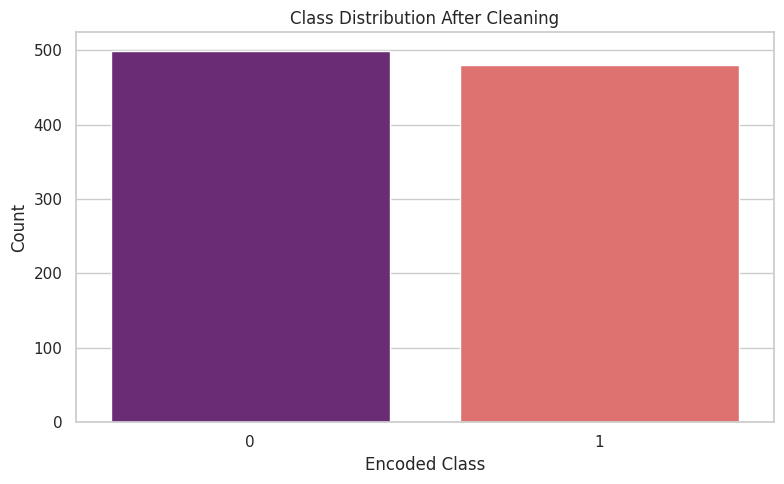

In [46]:
plt.figure(figsize=(8, 5))
sns.countplot(x="Class", data=df, palette="magma")
plt.title("Class Distribution After Cleaning")
plt.xlabel("Encoded Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

### **Split Data**

In [26]:
X = df['CleanTweet']
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)

Xtrain_length = len(X_train)
print(Xtrain_length)
Xtest_length = len(X_test)
Xtest_length

734


245

## **PART 1 (a) Sentiment Analysis Using Various Models**

In [27]:
vocab_size = 5000
oov_token = "<OOV>"
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token, filters='')  # don‚Äôt strip Urdu punct
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
max_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')
embedding_dim = 256
rnn_units = 256

### - **RNN**

Epoch 1/25


I0000 00:00:1745048176.804700      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745048176.805503      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1745048181.635162      98 service.cc:148] XLA service 0x7fa4b0007b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745048181.635885      98 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745048181.635905      98 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745048182.112593      98 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745048184.912252      98 device_compiler.h:188] Compiled clust

46/46 - 13s - 280ms/step - accuracy: 0.5163 - loss: 0.7408 - val_accuracy: 0.4490 - val_loss: 0.7121
Epoch 2/25
46/46 - 1s - 13ms/step - accuracy: 0.5136 - loss: 0.7407 - val_accuracy: 0.4980 - val_loss: 0.7437
Epoch 3/25
46/46 - 1s - 12ms/step - accuracy: 0.4959 - loss: 0.7434 - val_accuracy: 0.4939 - val_loss: 0.7160
Epoch 4/25
46/46 - 1s - 12ms/step - accuracy: 0.4877 - loss: 0.7507 - val_accuracy: 0.4816 - val_loss: 0.6984
Epoch 5/25
46/46 - 1s - 12ms/step - accuracy: 0.4918 - loss: 0.7399 - val_accuracy: 0.5510 - val_loss: 0.6913
Epoch 6/25
46/46 - 1s - 12ms/step - accuracy: 0.4837 - loss: 0.7325 - val_accuracy: 0.5265 - val_loss: 0.6963
Epoch 7/25
46/46 - 1s - 12ms/step - accuracy: 0.5245 - loss: 0.7085 - val_accuracy: 0.5061 - val_loss: 0.7204
Epoch 8/25
46/46 - 1s - 12ms/step - accuracy: 0.5082 - loss: 0.7180 - val_accuracy: 0.5061 - val_loss: 0.6965
Epoch 9/25
46/46 - 1s - 12ms/step - accuracy: 0.4755 - loss: 0.7284 - val_accuracy: 0.4694 - val_loss: 0.6950
Epoch 10/25
46/46 -

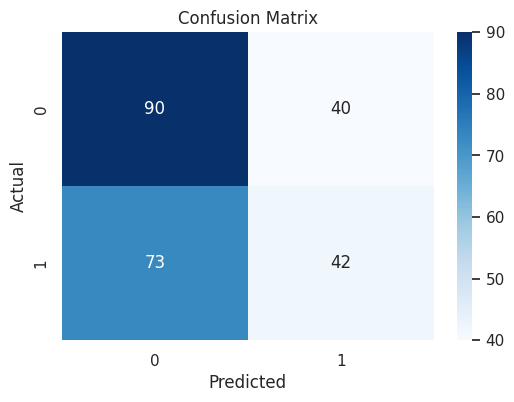

In [28]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    SimpleRNN(rnn_units, dropout=0.5, recurrent_dropout=0.3),
    Dense(32, activation='tanh'),
    Dropout(0.2),
    Dense(16, activation='tanh'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_pad, y_train, epochs=25, batch_size=16, validation_data=(X_test_pad, y_test), verbose = 3)
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
predictions = model.predict(X_test_pad)
predicted_classes = (predictions > 0.5).astype("int32")
cm = confusion_matrix(y_test, predicted_classes)
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(y_test, predicted_classes))
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

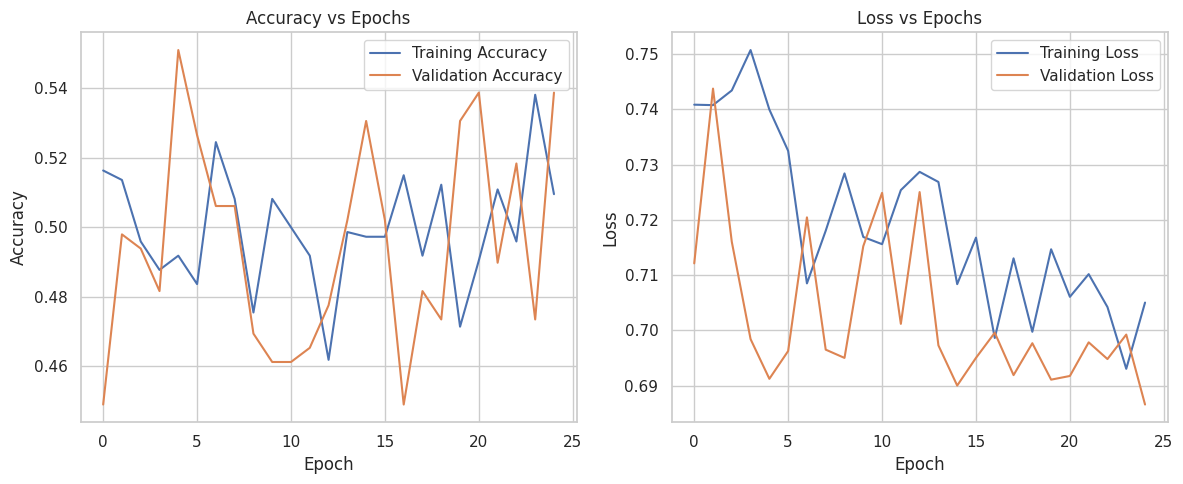

In [29]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()


### - **GRU**

Epoch 1/25
46/46 - 18s - 382ms/step - accuracy: 0.4809 - loss: 0.7064 - val_accuracy: 0.4694 - val_loss: 0.6932
Epoch 2/25
46/46 - 8s - 184ms/step - accuracy: 0.4850 - loss: 0.7005 - val_accuracy: 0.4694 - val_loss: 0.7018
Epoch 3/25
46/46 - 9s - 185ms/step - accuracy: 0.5068 - loss: 0.6975 - val_accuracy: 0.5306 - val_loss: 0.6920
Epoch 4/25
46/46 - 9s - 192ms/step - accuracy: 0.4619 - loss: 0.6980 - val_accuracy: 0.5306 - val_loss: 0.6921
Epoch 5/25
46/46 - 9s - 186ms/step - accuracy: 0.5177 - loss: 0.6941 - val_accuracy: 0.5306 - val_loss: 0.6914
Epoch 6/25
46/46 - 9s - 189ms/step - accuracy: 0.5054 - loss: 0.6950 - val_accuracy: 0.5306 - val_loss: 0.6929
Epoch 7/25
46/46 - 9s - 188ms/step - accuracy: 0.5354 - loss: 0.6924 - val_accuracy: 0.4694 - val_loss: 0.7028
Epoch 8/25
46/46 - 9s - 194ms/step - accuracy: 0.4700 - loss: 0.6971 - val_accuracy: 0.4694 - val_loss: 0.6945
Epoch 9/25
46/46 - 9s - 189ms/step - accuracy: 0.4768 - loss: 0.6968 - val_accuracy: 0.4694 - val_loss: 0.6943


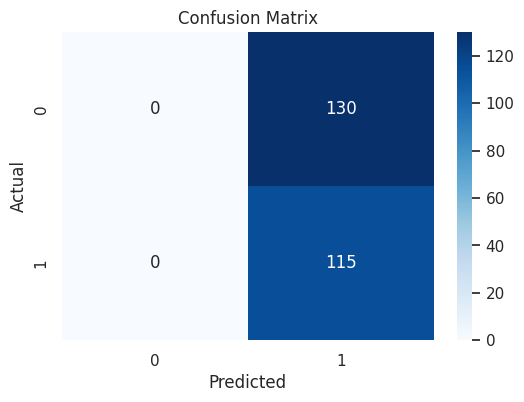

In [30]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    GRU(rnn_units, dropout=0.5, recurrent_dropout=0.3),
    Dense(16, activation='tanh'),
    Dense(8, activation='tanh'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_pad, y_train, epochs=25, batch_size=16,
                    validation_data=(X_test_pad, y_test), verbose=2)

test_loss, test_accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

predictions = model.predict(X_test_pad)
predicted_classes = (predictions > 0.5).astype("int32")
cm = confusion_matrix(y_test, predicted_classes)

print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(y_test, predicted_classes))

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

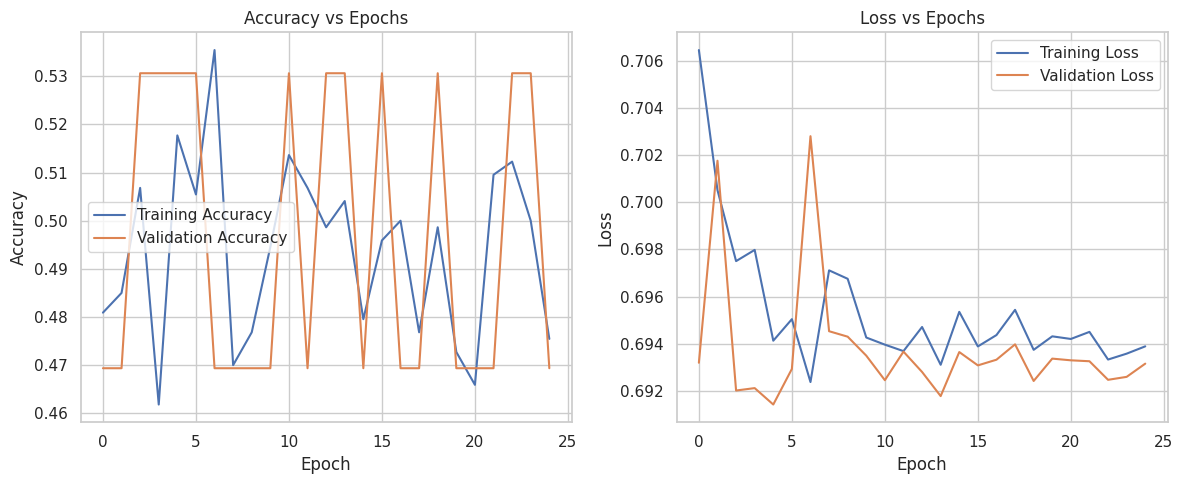

In [31]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()


### - **LSTM**

Epoch 1/25
46/46 - 14s - 308ms/step - accuracy: 0.5177 - loss: 0.6989 - val_accuracy: 0.5306 - val_loss: 0.6915
Epoch 2/25
46/46 - 8s - 176ms/step - accuracy: 0.4864 - loss: 0.7001 - val_accuracy: 0.5306 - val_loss: 0.6913
Epoch 3/25
46/46 - 8s - 177ms/step - accuracy: 0.5000 - loss: 0.6955 - val_accuracy: 0.4694 - val_loss: 0.6945
Epoch 4/25
46/46 - 8s - 177ms/step - accuracy: 0.5136 - loss: 0.6972 - val_accuracy: 0.5306 - val_loss: 0.6914
Epoch 5/25
46/46 - 8s - 179ms/step - accuracy: 0.4918 - loss: 0.6966 - val_accuracy: 0.5306 - val_loss: 0.6916
Epoch 6/25
46/46 - 8s - 175ms/step - accuracy: 0.5041 - loss: 0.6972 - val_accuracy: 0.5306 - val_loss: 0.6924
Epoch 7/25
46/46 - 8s - 178ms/step - accuracy: 0.4973 - loss: 0.6975 - val_accuracy: 0.4694 - val_loss: 0.6956
Epoch 8/25
46/46 - 8s - 177ms/step - accuracy: 0.5218 - loss: 0.6950 - val_accuracy: 0.4694 - val_loss: 0.6941
Epoch 9/25
46/46 - 8s - 182ms/step - accuracy: 0.4837 - loss: 0.6978 - val_accuracy: 0.4694 - val_loss: 0.6939


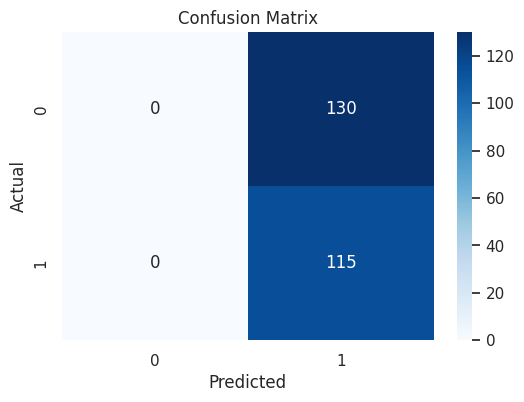

In [32]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(rnn_units, dropout=0.5, recurrent_dropout=0.3),
    Dense(32, activation='tanh'),
    Dropout(0.2),
    Dense(16, activation='tanh'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_pad, y_train, epochs=25, batch_size=16,
                    validation_data=(X_test_pad, y_test), verbose=2)

test_loss, test_accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

predictions = model.predict(X_test_pad)
predicted_classes = (predictions > 0.5).astype("int32")
cm = confusion_matrix(y_test, predicted_classes)

print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(y_test, predicted_classes))

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

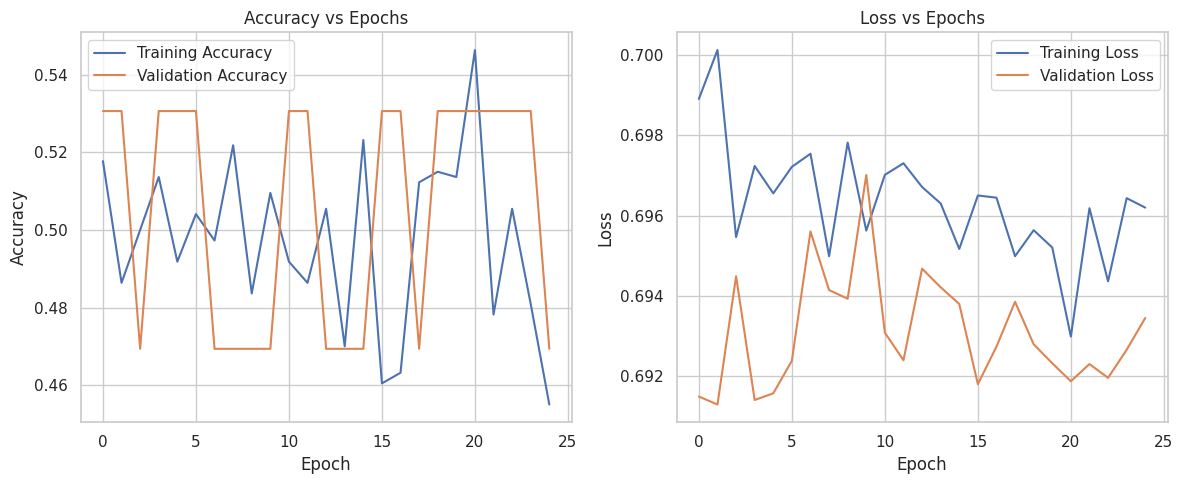

In [33]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()


### - **BiLSTM**

Epoch 1/10
46/46 - 20s - 428ms/step - accuracy: 0.5123 - loss: 0.7046 - val_accuracy: 0.5388 - val_loss: 0.6877
Epoch 2/10
46/46 - 11s - 246ms/step - accuracy: 0.8052 - loss: 0.5176 - val_accuracy: 0.6367 - val_loss: 0.6926
Epoch 3/10
46/46 - 11s - 244ms/step - accuracy: 0.9605 - loss: 0.1288 - val_accuracy: 0.5837 - val_loss: 1.0319
Epoch 4/10
46/46 - 12s - 253ms/step - accuracy: 0.9918 - loss: 0.0344 - val_accuracy: 0.5796 - val_loss: 1.2852
Epoch 5/10
46/46 - 11s - 242ms/step - accuracy: 0.9946 - loss: 0.0263 - val_accuracy: 0.6163 - val_loss: 1.3837
Epoch 6/10
46/46 - 11s - 244ms/step - accuracy: 0.9550 - loss: 0.1302 - val_accuracy: 0.6082 - val_loss: 1.0787
Epoch 7/10
46/46 - 11s - 249ms/step - accuracy: 0.9946 - loss: 0.0317 - val_accuracy: 0.6204 - val_loss: 1.2140
Epoch 8/10
46/46 - 11s - 239ms/step - accuracy: 0.9986 - loss: 0.0120 - val_accuracy: 0.6245 - val_loss: 1.3356
Epoch 9/10
46/46 - 11s - 244ms/step - accuracy: 0.9986 - loss: 0.0129 - val_accuracy: 0.6163 - val_loss:

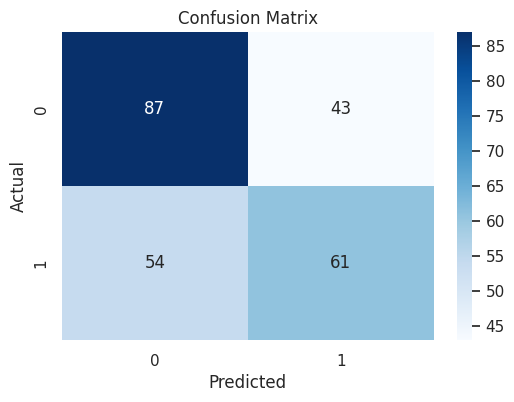

In [34]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(rnn_units, dropout=0.1, recurrent_dropout=0.3)),
    Dense(32, activation='tanh'),
    Dropout(0.2),
    Dense(16, activation='tanh'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=16,
                    validation_data=(X_test_pad, y_test), verbose=2)

test_loss, test_accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

predictions = model.predict(X_test_pad)
predicted_classes = (predictions > 0.5).astype("int32")
cm = confusion_matrix(y_test, predicted_classes)

print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(y_test, predicted_classes))

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

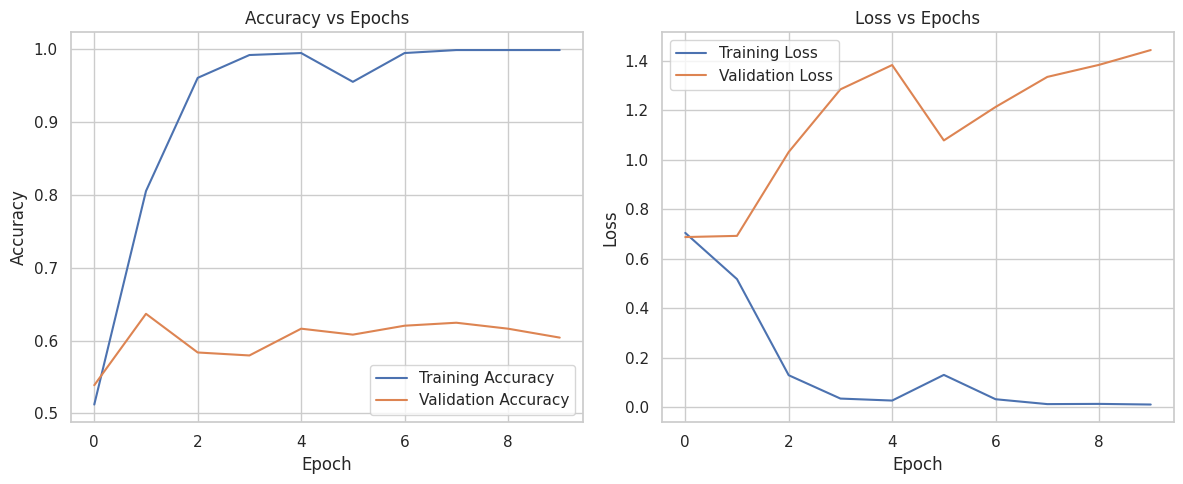

In [35]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()


### - **mBERT**

`!pip install transformers datasets`

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
bert_model = TFBertModel.from_pretrained("bert-base-multilingual-cased")

class BertLayer(tf.keras.layers.Layer):
    def __init__(self, bert, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert = bert

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.pooler_output

input_ids = tf.keras.Input(shape=(100,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.Input(shape=(100,), dtype=tf.int32, name="attention_mask")

bert_output = tf.keras.layers.Lambda(
    lambda inputs: xlm_roberta(inputs['input_ids'], attention_mask=inputs['attention_mask'])[0][:, 0],
    output_shape=(768,)
)({'input_ids': input_ids, 'attention_mask': attention_mask})

x = tf.keras.layers.Dropout(0.3)(bert_output)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_dataset, validation_data=test_dataset, epochs=25, verbose = 3)

preds = model.predict(test_dataset)
predicted = (preds.flatten() > 0.5).astype(int)

cm = confusion_matrix(y_test, predicted)
print("Classification Report:\n", classification_report(y_test, predicted))

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

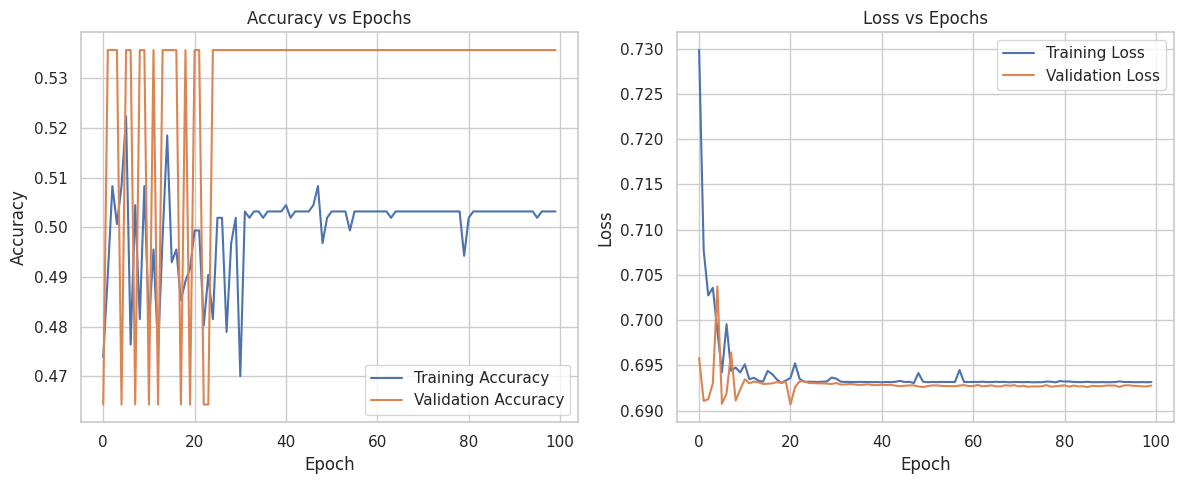

In [62]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()


### - **XLM-RoBERTa**

In [60]:
from transformers import TFXLMRobertaModel, XLMRobertaTokenizer

# ‚úÖ 1. Prepare data
texts = df['CleanTweet'].astype(str).tolist()
labels = df['Class'].astype(int).tolist()

X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# ‚úÖ 2. Tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

def tokenize(texts):
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=100,
        return_tensors='tf'
    )

train_enc = tokenize(X_train)
test_enc = tokenize(X_test)

# ‚úÖ 3. Dataset
batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': train_enc['input_ids'],
        'attention_mask': train_enc['attention_mask']
    },
    tf.convert_to_tensor(y_train)
)).shuffle(1000).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': test_enc['input_ids'],
        'attention_mask': test_enc['attention_mask']
    },
    tf.convert_to_tensor(y_test)
)).batch(batch_size)

# ‚úÖ 4. Model
xlm_roberta = TFXLMRobertaModel.from_pretrained('xlm-roberta-base')

input_ids = tf.keras.Input(shape=(100,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.Input(shape=(100,), dtype=tf.int32, name="attention_mask")

# üí° Wrap model call inside a Lambda layer to avoid KerasTensor errors
bert_output = tf.keras.layers.Lambda(
    lambda inputs: xlm_roberta(inputs['input_ids'], attention_mask=inputs['attention_mask'])[0][:, 0]
)({'input_ids': input_ids, 'attention_mask': attention_mask})

x = tf.keras.layers.Dropout(0.3)(bert_output)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

# ‚úÖ 5. Fine-tune
for layer in xlm_roberta.layers:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# ‚úÖ 6. Train
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=4,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
    ]
)

# ‚úÖ 7. Evaluate
preds = model.predict(test_dataset)
predicted = (preds.flatten() > 0.5).astype(int)

cm = confusion_matrix(y_test, predicted)
print("Classification Report:\n", classification_report(y_test, predicted))

# ‚úÖ 8. Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFXLMRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


NotImplementedError: Exception encountered when calling Lambda.call().

[1mWe could not automatically infer the shape of the Lambda's output. Please specify the `output_shape` argument for this Lambda layer.[0m

Arguments received by Lambda.call():
  ‚Ä¢ args=({'input_ids': '<KerasTensor shape=(None, 100), dtype=int32, sparse=False, name=input_ids>', 'attention_mask': '<KerasTensor shape=(None, 100), dtype=int32, sparse=False, name=attention_mask>'},)
  ‚Ä¢ kwargs={'mask': {'input_ids': 'None', 'attention_mask': 'None'}}